# Emittance minimization using Xopt with BAXGenerator running algorithm ScipyMinimizeEmittance
In this notebook we demonstrate the use of Xopt to perform Bayesian Algorithm Execution (BAX) as a means of minimizing the emittance described by a simple optical beam size model. BAX is a generalization of Bayesian Optimization that seeks to acquire observations that provide our model with maximal information about our property of interest. In this example, our property of interest is the minimal emittance and its location in tuning-parameter-space. See https://arxiv.org/pdf/2209.04587.pdf for details.

# Imports

In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import sys
# sys.path.append('C:\\Users\\Dylan\\SLAC') #parent directory containing emitopt module

import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import pandas as pd
import torch

from xopt import Xopt
from xopt.vocs import VOCS
from xopt.generators.bayesian.bax_generator import BaxGenerator

from xopt.evaluator import Evaluator

from emitopt.utils import (post_path_emit_squared,
                           compute_emits,
                           get_meas_scan_inputs_from_tuning_configs,
                           get_valid_emittance_samples)
from emitopt.sampling import draw_product_kernel_post_paths
from emitopt.algorithms import ScipyMinimizeEmittance

import time
import numpy as np
import random

# Use CUDA if available

In [2]:
# if torch.cuda.is_available():
if False:
    torch.set_default_tensor_type('torch.cuda.DoubleTensor')
    use_cuda = True
else:
    torch.set_default_tensor_type('torch.DoubleTensor')
    use_cuda = False

# Notebook settings

In [3]:
ndim = 6 #number of input dimensions
noise = False #whether to add noise to the ground-truth beam size function outputs
meas_dim = 1 #input dimension for measurement parameter
n_obs_init = 30 #number of random initial observations for GP model
n_samples = 10 #number of posterior samples for BAX
n_iter = 10 #number of optimization steps for Xopt to take (after acquiring random initial data)
rand_seed = 2

#random seeds for reproducibility 
torch.manual_seed(rand_seed)
np.random.seed(rand_seed) #only affects initial random observations through Xopt
random.seed(rand_seed)

# Build test function from single-quadrupole optical beam size model 
Here we define a simple ground-truth beam size function for our optimization problem, where we attempt to find the location in tuning parameter space with minimal emittance. Note that the function "test_func" used to evaluate the ground-truth beam size function takes a dictionary as input and returns a dictionary as the output.

In [4]:
# define test functions
var_names = ['x' + str(i) for i in range(ndim)]
meas_param = var_names[meas_dim]

beam_energy = 0.135
distance = torch.tensor(2.26).double()
q_len = torch.tensor(0.108).double()
s11 = torch.tensor(3e-6).double()
s12 = torch.tensor(1.5e-6).double()
s22 = torch.tensor(2e-6).double()
gt_min_emit = torch.sqrt(s11 * s22 - s12 ** 2)*1e6
print('Ground-Truth Minimum Emittance:', gt_min_emit.item())



def beam_size_squared(k, d, l, s11, s12, s22):
    return (
        (1.0 + k * d * l) ** 2 * s11 + 2.0 * (1.0 + d * l * k) * d * s12 + d ** 2 * s22
    )
    
def toy_beam_size_squared_nd(x, meas_dim, noise=noise):
    
    tuning_dims = list(range(x.shape[-1]))
    tuning_dims.remove(meas_dim)
    emit = torch.sqrt(s11 * s22 - s12 ** 2)
    bss = ((1 + torch.sum(x[:,tuning_dims]**2, dim=1) )* beam_size_squared(x[:,meas_dim], distance, q_len, s11, s12, s22)).reshape(-1,1) 
    bss *= 1.e6
    if noise:
        bss *= (1 + 0.05*torch.rand_like(bss))      
    return bss

def toy_emit_nd(X_tuning):
    return (1 + torch.sum(X_tuning**2, dim=1) ) * gt_min_emit

def test_func(input_dict):
    x = torch.tensor(input_dict[meas_param]).reshape(-1,1)
    for key in input_dict.keys():
        if key is not meas_param:
            x = torch.cat((x, torch.tensor(input_dict[key]).reshape(-1,1)), dim=1)
    return {'y': float(toy_beam_size_squared_nd(x, 0).squeeze().cpu().numpy()),
           'emittance': float(toy_emit_nd(x[:,1:]).squeeze().cpu().numpy())}

Ground-Truth Minimum Emittance: 1.9364916731037083


# Construct vocs

In [5]:
variables = {var_name: [-3,1] for var_name in var_names}
variables[meas_param] = [-40,40] #overwrite bounds for measurement parameter to capture minimum of single-quadrupole optical model

#construct vocs
vocs = VOCS(
    variables = variables,
    objectives = {'y':"MINIMIZE"}
)

print('variable_names =', vocs.variable_names)
print('meas_param =', "'" + meas_param + "'")
print('domain =\n', vocs.bounds.T)

variable_names = ['x0', 'x1', 'x2', 'x3', 'x4', 'x5']
meas_param = 'x1'
domain =
 [[ -3.   1.]
 [-40.  40.]
 [ -3.   1.]
 [ -3.   1.]
 [ -3.   1.]
 [ -3.   1.]]


# Prepare generator options.
In this example, we use a specialty covariance module (Matern x Quadratic kernel) for our beam size model.

In [6]:
from gpytorch.kernels import MaternKernel, PolynomialKernel, ScaleKernel
from gpytorch.priors.torch_priors import GammaPrior

from xopt.generators.bayesian.models.standard import StandardModelConstructor
from xopt.generators.bayesian.bax_generator import BaxGenerator
from emitopt.algorithms import ScipyMinimizeEmittance

# prepare custom covariance module
tuning_dims = list(range(vocs.n_variables))
tuning_dims.remove(meas_dim)
covar_module = MaternKernel(active_dims=tuning_dims, lengthscale_prior=GammaPrior(3.0, 6.0)) * PolynomialKernel(
    power=2, active_dims=[meas_dim]
)
scaled_covar_module = ScaleKernel(covar_module, outputscale_prior=GammaPrior(2.0, 0.15))   

# prepare options for Xopt generator
covar_module_dict = {'y': scaled_covar_module}

model_constructor = StandardModelConstructor(covar_modules=covar_module_dict, use_low_noise_prior=True)

In [7]:
from xopt.numerical_optimizer import LBFGSOptimizer
numerical_optimizer = LBFGSOptimizer(
                                    n_raw_samples=20,
                                    n_restarts=20,
                                    max_iter=100)

# Construct generator, evaluator, Xopt objects

In [8]:
#Prepare Algorithm
from emitopt.utils import get_quad_strength_conversion_factor
# scale_factor = get_quad_strength_conversion_factor(E=beam_energy, q_len=q_len)
scale_factor = 1.
algo_kwargs = {
        'scale_factor': scale_factor,
        'q_len': q_len,
        'distance': distance,
        'n_samples': n_samples,
        'meas_dim': meas_dim,
        'n_steps_measurement_param': 3,
        'n_steps_exe_paths':  11}
algo = ScipyMinimizeEmittance(**algo_kwargs)

#construct BAX generator
generator = BaxGenerator(vocs=vocs, 
                         model_constructor=model_constructor, 
                         numerical_optimizer=numerical_optimizer,
                         algorithm=algo, 
                         use_cuda=use_cuda)

#construct evaluator
evaluator = Evaluator(function=test_func)

#construct Xopt optimizer
optimizer = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

# Optimize

In [9]:
# call X.random_evaluate() to generate random initial points and evaluate on test_func
optimizer.random_evaluate(n_obs_init)

,x0,x1,x2,x3,x4,x5,y,emittance,xopt_runtime,xopt_error
1,-0.743980,2.577001,-2.201033,-0.253034,-1.191631,0.649750,242.655293,16.081091,0.000750,False
2,0.896295,23.860542,-1.407268,0.832809,-1.798082,0.877642,1663.715181,16.422760,0.000302,False
3,-1.198650,-11.232538,-2.059839,-1.953599,0.016755,-0.428540,80.173977,20.682073,0.000296,False
4,-0.741290,1.354413,0.323098,-1.630050,0.253491,-1.359128,152.748340,12.049724,0.000294,False
5,-0.681471,-0.418938,-0.172093,0.141457,0.557667,0.791109,45.879798,4.746100,0.000295,False
6,-0.321339,9.048588,-1.096268,-0.667014,-0.096237,0.737345,207.602037,6.396055,0.000292,False
7,0.181405,-23.490996,-0.426497,-1.575368,0.959000,0.825995,240.257428,10.260579,0.000290,False
8,-1.477084,-6.400334,0.817284,-1.645925,-1.517439,-0.580603,67.624879,17.812859,0.000288,False
9,-0.198619,27.016112,-2.932614,0.318091,-0.180689,-1.673708,2951.480733,24.351001,0.000287,False
10,-0.067309,-16.060188,-0.765420,-2.526609,0.250854,0.207892,129.256347,15.647428,0.000292,False


In [10]:
optimizer.data

,x0,x1,x2,x3,x4,x5,y,emittance,xopt_runtime,xopt_error
1,-0.743980,2.577001,-2.201033,-0.253034,-1.191631,0.649750,242.655293,16.081091,0.000750,False
2,0.896295,23.860542,-1.407268,0.832809,-1.798082,0.877642,1663.715181,16.422760,0.000302,False
3,-1.198650,-11.232538,-2.059839,-1.953599,0.016755,-0.428540,80.173977,20.682073,0.000296,False
4,-0.741290,1.354413,0.323098,-1.630050,0.253491,-1.359128,152.748340,12.049724,0.000294,False
5,-0.681471,-0.418938,-0.172093,0.141457,0.557667,0.791109,45.879798,4.746100,0.000295,False
6,-0.321339,9.048588,-1.096268,-0.667014,-0.096237,0.737345,207.602037,6.396055,0.000292,False
7,0.181405,-23.490996,-0.426497,-1.575368,0.959000,0.825995,240.257428,10.260579,0.000290,False
8,-1.477084,-6.400334,0.817284,-1.645925,-1.517439,-0.580603,67.624879,17.812859,0.000288,False
9,-0.198619,27.016112,-2.932614,0.318091,-0.180689,-1.673708,2951.480733,24.351001,0.000287,False
10,-0.067309,-16.060188,-0.765420,-2.526609,0.250854,0.207892,129.256347,15.647428,0.000292,False


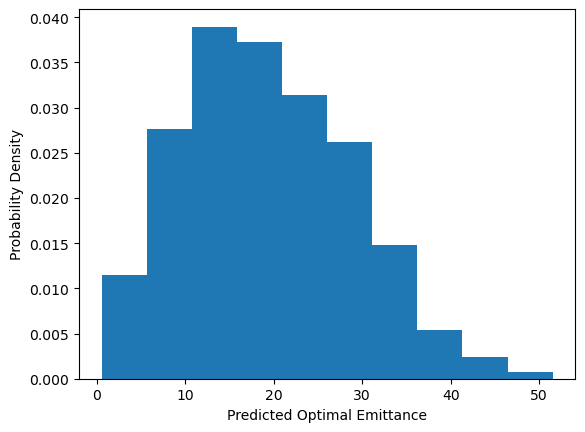

sample validity rate: tensor([0.1915])
Iteration: 1 / 10
acq func _n_evals: 184
This iteration took: 5.9889185428619385 seconds.

Iteration: 2 / 10
acq func _n_evals: 178
This iteration took: 5.4198784828186035 seconds.

Iteration: 3 / 10
acq func _n_evals: 164
This iteration took: 3.150444984436035 seconds.

Iteration: 4 / 10
acq func _n_evals: 187
This iteration took: 3.3880279064178467 seconds.

Iteration: 5 / 10
acq func _n_evals: 174
This iteration took: 3.8375492095947266 seconds.

Iteration: 6 / 10
acq func _n_evals: 174
This iteration took: 3.736293315887451 seconds.

Iteration: 7 / 10
acq func _n_evals: 179
This iteration took: 3.64752197265625 seconds.

Iteration: 8 / 10
acq func _n_evals: 179
This iteration took: 2.821582078933716 seconds.

Iteration: 9 / 10
acq func _n_evals: 186
This iteration took: 4.784122943878174 seconds.

Iteration: 10 / 10
acq func _n_evals: 190
This iteration took: 4.477065801620483 seconds.



In [11]:
results = {}
beam_size_models = {}

#get initial emittance prediction at ground truth optimum
beam_size_model = optimizer.generator.train_model().models[0]


#get mean-predicted optimal tuning config and eval predicted emits at this location in tuning parameter space
algo = optimizer.generator.algorithm
X_tuned, emits_at_target_valid, svr = algo.mean_output(beam_size_model, 
                                                                                     torch.tensor(vocs.bounds), 
                                                                                     num_restarts=10)


plt.hist(emits_at_target_valid.flatten().cpu(), density=True)
plt.xlabel('Predicted Optimal Emittance')
plt.ylabel('Probability Density')
plt.show()
print('sample validity rate:', svr)

for i in range(1, n_iter+1):

    print('Iteration:', i, '/', n_iter)

    start = time.time()

    # call X.step() to generate a random initial point and evaluate on test_func
    optimizer.step()    

    
    #extract GP model
    beam_size_model = optimizer.generator.model.models[0]
    
    #extract and store algorithm results for this iteration
    results[i] = optimizer.generator.algorithm_results
    beam_size_models[i] = beam_size_model
    
    #get mean-predicted optimal tuning config and eval predicted emits at this location in tuning parameter space
    algo = optimizer.generator.algorithm
#     X_tuned, emits_at_target_valid, svr = algo.mean_output(beam_size_model,
#                                                          torch.tensor(vocs.bounds),
#                                                          num_restarts=10)
    
    end = time.time()
    print('This iteration took:', end-start, 'seconds.\n')

#     if i % 5 == 0:
#         plt.hist(emits_at_target_valid.flatten().cpu(), density=True)
#         plt.xlabel('Predicted Optimal Emittance')
#         plt.ylabel('Probability Density')
#         plt.show()
#         print('sample validity rate:', svr)

In [12]:
start = time.time()
acq = optimizer.generator.get_acquisition(optimizer.generator.model)
end = time.time()
print('get_acquisition took', end-start, 'seconds.')

get_acquisition took 1.751603126525879 seconds.


In [13]:
from botorch.optim.optimize import optimize_acqf
start = time.time()
for i in range(1):
    res = optimize_acqf(acq_function=acq,
                        bounds=torch.tensor(vocs.bounds),
                        q=1,
                        num_restarts=50,
                        raw_samples=50,
                        options={'maxiter':100}
                       )
end = time.time()
print('optimize_acqf took', end-start, 'seconds.')

optimize_acqf took 2.1115760803222656 seconds.


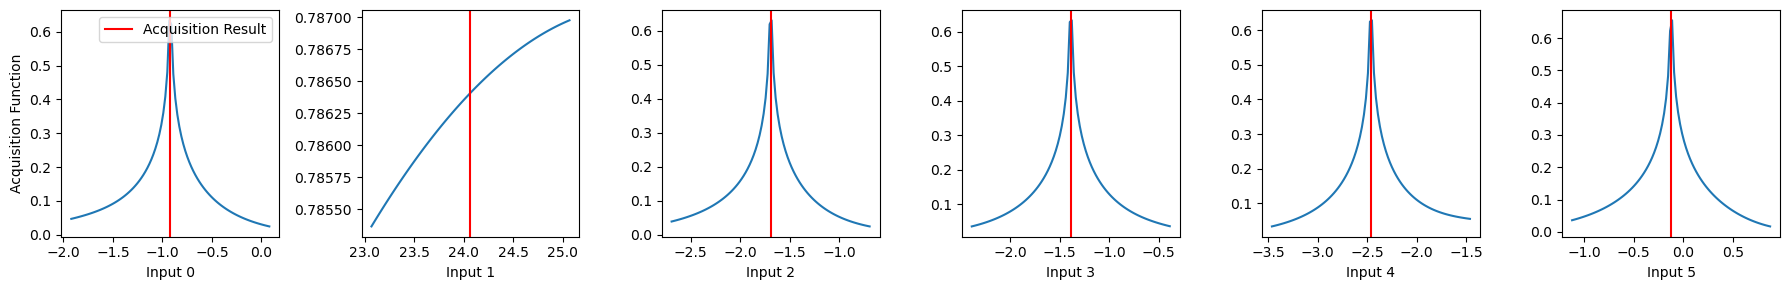

In [14]:
# acq = optimizer.generator.get_acquisition(optimizer.generator.model)

# last_acq = np.vstack(data_all[0].iloc[-1][list(vocs.variable_data([vocs.random_inputs()], '').keys())].values[:]).astype(float)
# last_acq = torch.tensor(last_acq).reshape(1,-1)

last_acq = res[0]

fig, axs = plt.subplots(1, ndim)
    
fig.set_size_inches(3*(ndim), 3)

for scan_dim in range(ndim):
    X_scan = last_acq.repeat(100,1)
#     ls = torch.linspace(*vocs.bounds.T[scan_dim],100)
    ls = torch.linspace(last_acq[0,scan_dim]-1,last_acq[0,scan_dim]+1,100)

    X_scan[:,scan_dim] = ls

    acq_scan = torch.tensor([acq(X.reshape(1,-1)) for X in X_scan]).reshape(-1)
    
    ax = axs[scan_dim]
    
    ax.plot(ls.cpu(), acq_scan.detach().cpu())
    ax.axvline(last_acq[0,scan_dim].cpu(), c='r', label='Acquisition Result')
    
    
    ax.set_xlabel('Input ' + str(scan_dim))
    
    if scan_dim == 0:
        ax.set_ylabel('Acquisition Function')
        ax.legend()
    
plt.tight_layout()
plt.show()

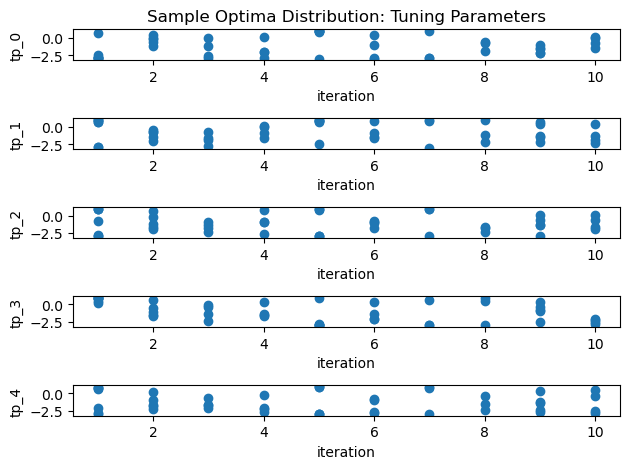

In [15]:
from emitopt.utils import plot_sample_optima_convergence_inputs
plot_sample_optima_convergence_inputs(results)

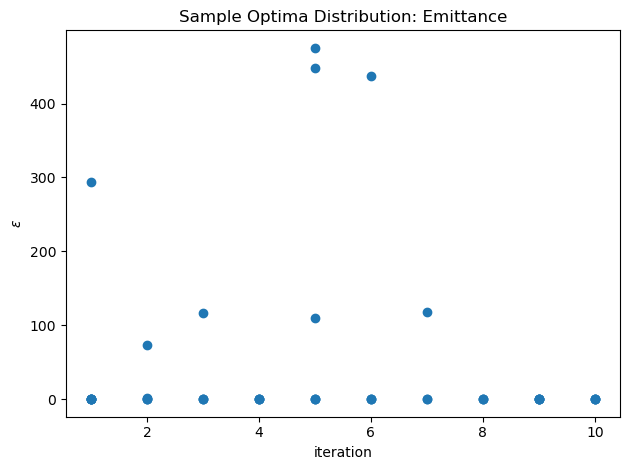

In [16]:
from emitopt.utils import plot_sample_optima_convergence_emits
plot_sample_optima_convergence_emits(results)

x_tuned = tensor([[-0.4210, -0.7006, -0.9423, -1.4149, -1.0923]])


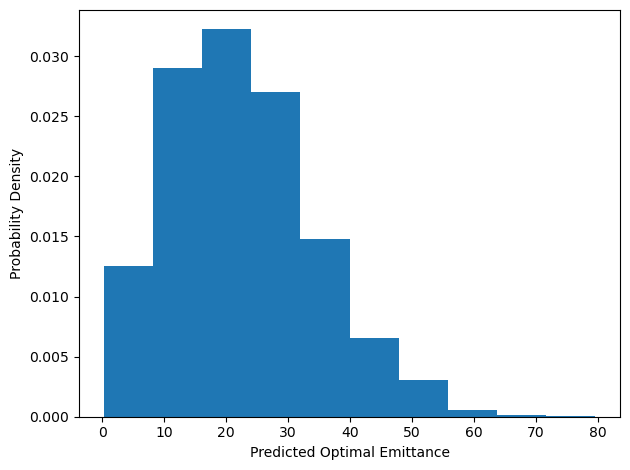

sample validity rate: tensor([0.3698])


In [17]:
from emitopt.utils import plot_valid_emit_prediction_at_x_tuning

x_tuned = torch.mean(results[n_iter]['x_stars_all'], dim=0, keepdim=True)
print('x_tuned =', x_tuned)
plot_valid_emit_prediction_at_x_tuning(beam_size_model, 
                                       x_tuned, 
                                       scale_factor = algo_kwargs['scale_factor'],
                                       q_len = algo_kwargs['q_len'],
                                       distance = algo_kwargs['distance'],
                                       bounds = vocs.bounds,
                                       meas_dim = algo_kwargs['meas_dim'],
                                       n_samples = 10000,
                                       n_steps_quad_scan = 10
                                        )

# Plot some beam size surface samples from our current model and do a scan of the predicted emittance as a function of our single tuning parameter.

In [18]:
if ndim==2:
    
    device = torch.tensor(1).device
    torch.set_default_tensor_type('torch.DoubleTensor')

    fig, axs = plt.subplots(1, 3, subplot_kw={"projection": "3d"})
    fig.set_size_inches(15,10)

    ax = axs[0]

    for s in range(3):

        # plot first 3 beam size surface samples
        xlin, ylin = torch.arange(-3,1,0.05), torch.arange(-40,40, 1.)
        X, Y = torch.meshgrid(xlin, ylin)
        XY = torch.cat((X.reshape(-1,1), Y.reshape(-1,1)), dim=1)
        print(XY.shape)
        Z = optimizer.generator.algorithm_results['post_paths_cpu'](XY)[s].reshape(X.shape).detach()
        cmap='viridis'
        surf = ax.plot_surface(Y, X, Z, cmap=cmap,
                               linewidth=0, antialiased=True, alpha=0.3, rasterized=True)

        # add orange parabolic highlights
        ax.plot(Y[0,:].numpy(), Z[0,:].numpy(), zs=X[0,0].item(), zdir='y', c='C1', lw=2, zorder=10)
        ax.plot(Y[int(len(Z[0,:])/2),:].numpy(), Z[int(len(Z[0,:])/2),:].numpy(), zs=X[int(len(Z[0,:])/2),0].item(), zdir='y', c='C1', lw=2)
        ax.plot(Y[-1,:].numpy(), Z[-1,:].numpy(), zs=X[-1,0].item(), zdir='y', c='C1', lw=2)




    # plot initial observations
    x0 = torch.tensor(optimizer.data['x0'].values)[:n_obs_init]
    x1 = torch.tensor(optimizer.data['x1'].values)[:n_obs_init]
    y = torch.tensor([item.item() for item in optimizer.data['y'].values])[:n_obs_init]
    ax.scatter(x1.flatten(), x0.flatten(), y.flatten(), marker='o', c='C0', alpha=1, s=80, label='Random (Initial) Observations', zorder=15)

    # plot bax observations
    x0 = torch.tensor(optimizer.data['x0'].values)[n_obs_init:]
    x1 = torch.tensor(optimizer.data['x1'].values)[n_obs_init:]
    y = torch.tensor([item.item() for item in optimizer.data['y'].values])[n_obs_init:]
    ax.scatter(x1.flatten(), x0.flatten(), y.flatten(), marker='o', c='C1', alpha=1, s=80, label='BAX Observations', zorder=15)

    ax.set_title('Beam Size Surface Samples')
    ax.set_ylabel('Tuning Parameter')
    ax.set_xlabel('Measurement Parameter')
    ax.set_zlabel('Beam Size Squared')

    ax.set_ylim(-3, 1)
    ax.set_zlim(0)
    
    # remove tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

    ax.legend()
    ax.dist = 12

    
    
    if device.type == "cuda":
        torch.set_default_tensor_type("torch.cuda.DoubleTensor")
        
   

    # do a scan (along the tuning dimension) of our emittance predictions
    emit_lowers = torch.tensor([])
    emit_uppers = torch.tensor([])
    emit_meds = torch.tensor([])
    for tuning_param in xlin:
        x_tuning = tuning_param.reshape(1,-1).to(device)
        emits, emits_sq_all, is_valid, svr = get_valid_emittance_samples(beam_size_model, 
                                                                         scale_factor, 
                                                                         0.108, 
                                                                         2.26, 
                                                                         x_tuning, 
                                                                         vocs.bounds.T, 
                                                                         meas_dim, 
                                                                         n_samples=10000, 
                                                                         n_steps_quad_scan=10)
        emit_lower = torch.quantile(emits, q=0.025, dim=0)
        emit_upper = torch.quantile(emits, q=0.975, dim=0)
        emit_med = torch.quantile(emits, q=0.5, dim=0)

        emit_lowers = torch.cat((emit_lowers, emit_lower))
        emit_uppers = torch.cat((emit_uppers, emit_upper))
        emit_meds = torch.cat((emit_meds, emit_med))

    #get a few batches of n_samples pathwise sample optima
    x_stars_all = torch.tensor([])
    emit_stars_all = torch.tensor([])
    for i in range(5):
        algo = optimizer.generator.algorithm
        results_dict = algo.get_execution_paths(beam_size_model, torch.tensor(vocs.bounds))[-1]
        x_stars = results_dict['x_stars']
        emit_stars = results_dict['emit_stars'].detach()
        x_stars_all = torch.cat((x_stars_all, x_stars), dim=0)
        emit_stars_all = torch.cat((emit_stars_all, emit_stars), dim=0)
    
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    import matplotlib.patches as mpatches

    ax = axs[1]
    
    # plot median emittance curve
    medline, = ax.plot(emit_meds.cpu().numpy(), xlin.numpy(), zs=0, zdir='z', c='g', label='Median')
    
    opt_cross = ax.scatter(emit_stars.flatten().cpu(), x_stars.flatten().cpu(), zs=0, zdir='z', marker='x', s=40, c='m', alpha=0.5, label='Sample Optima')
    
    # plot emittance 95% confidence interval as a Poly3DCollection (ordering of vertices matters)
    verts = (
        [(emit_lowers[i].item(), xlin[i].item(), 0) for i in range(len(xlin))] + 
        [(emit_uppers[i].item(), xlin[i].item(), 0) for i in range(len(xlin))][::-1]
    )
    ax.add_collection3d(Poly3DCollection([verts],color='g', edgecolor='None', alpha=0.5)) # Add a polygon instead of fill_between

    
    ax.set_xlabel('Emittance')
    ax.set_ylabel('Tuning Parameter')
    ax.set_title('Emittance Measurement Samples')
    
    ax.set_xlim(0,25)
    ax.set_ylim(-3,1)
    ax.set_zlim(0,1)

    # remove vertical tick marks
    ax.set_zticks([])

    # remove tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

    orange_patch = mpatches.Patch(color='g', alpha=0.5, label='95% C.I.')
    ax.legend(handles=[medline, orange_patch, opt_cross])
    ax.dist = 12

    
    
    ax = axs[2]
    bins = 10
    freq, edges = torch.histogram(x_stars_all.flatten().cpu(), bins=bins, density=True)
    for i in range(bins):
        uverts = []
        lverts = []
        uverts += [(freq[i].item(), edges[i].item(), 0), (freq[i].item(), edges[i+1].item(), 0)]
        lverts += [(0, edges[i+1].item(), 0), (0, edges[i].item(), 0)]
        verts = uverts + lverts
        ax.add_collection3d(Poly3DCollection([verts],color='m', edgecolor='k')) # Add a polygon instead of fill_between

    ax.set_title('Distribution of Sample Optimal Tuning Parameters')
    ax.set_ylabel('Tuning Parameter')
    ax.set_xlabel('Frequency')
    
    ax.set_xlim(0,2)
    ax.set_ylim(-3,1)
    ax.set_zlim(0,1)
    
    # remove vertical tick marks
    ax.set_zticks([])

    # remove tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    
    ax.dist = 12

    plt.tight_layout()
    plt.savefig('beamsize-surfaces-with-emittance-1.svg', format='svg')
    plt.show()


# Minimize sample emittance functions produced by current GP beam size model and inspect results

In [19]:
#minimize sample emittances (by calling get_exe_paths) and time it
start = time.time()
algo = optimizer.generator.algorithm
X_sample_opt = algo.get_sample_optimal_tuning_configs(beam_size_model, torch.tensor(vocs.bounds))[0]
end = time.time()
print('get_sample_minima() took', end-start, 'seconds.')



print('Average x_tuned =', torch.mean(X_tuned, dim=0))

get_sample_minima() took 0.9195263385772705 seconds.
Average x_tuned = tensor([ 0.1861, -2.5939, -2.1056, -0.5887, -1.1783])


In [20]:
#select sample result

sid = 1 #sample index to examine

# X_tuned = X_sample_opt[sid].reshape(1,-1)
X_tuned = optimizer.generator.algorithm_results['x_stars_all'][sid:sid+1, :]
print('X_tuned =', X_tuned)

X_tuned = tensor([[ 0.9548, -2.9924,  0.4568, -2.0693, -2.0028]])


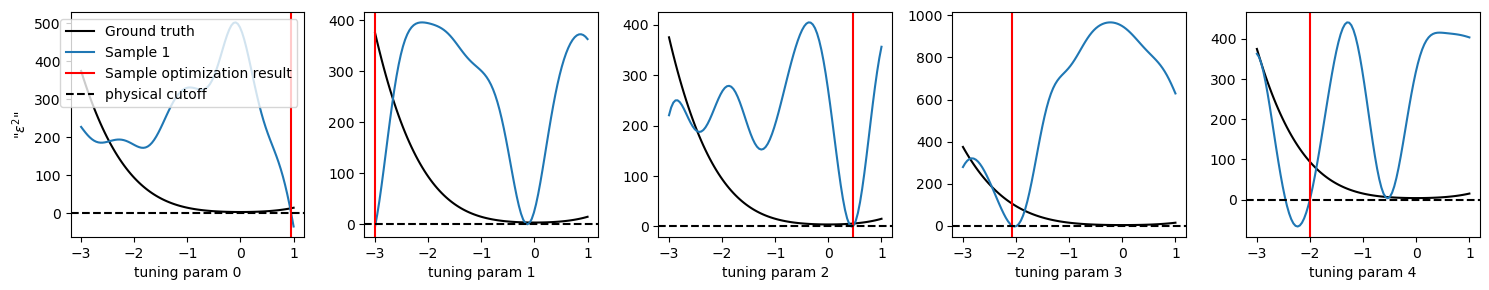

In [21]:
#plot sample emittance minimization result

fig, axs = plt.subplots(1, ndim-1)
if ndim == 2: axs = [axs]
    
fig.set_size_inches(3*(ndim-1), 3)

for scan_dim in range(ndim-1):
    X_tuning_scan = X_tuned.repeat(100,1)
    ls = torch.linspace(-3,1,100)
    X_tuning_scan[:,scan_dim] = ls
    X_meas = torch.linspace(-40,60,3)

    emits_sq = post_path_emit_squared(optimizer.generator.algorithm_results['post_paths_cpu'], 
                              optimizer.generator.algorithm.scale_factor, 
                              optimizer.generator.algorithm.q_len, 
                              optimizer.generator.algorithm.distance, 
                              X_tuning_scan.cpu(), meas_dim, X_meas.cpu(), samplewise=False)[0]
        
    ax = axs[scan_dim]
    
    ax.plot(ls.cpu(), (toy_emit_nd(ls.reshape(-1,1))**2).cpu(), c='k', label='Ground truth') #this ground truth isn't exactly the matching cross-section but it should be close

    ax.plot(ls.cpu(), emits_sq[sid].detach().cpu(), label='Sample ' + str(sid))
    ax.axvline(X_tuned[0,scan_dim].cpu(), c='r', label='Sample optimization result')
    ax.axhline(0, c='k', ls='--', label='physical cutoff')
    
    ax.set_xlabel('tuning param ' + str(scan_dim))
    
    if scan_dim == 0:
        ax.set_ylabel('"$\epsilon^{2}$"')
        ax.legend()
    
plt.tight_layout()
plt.show()
